In [21]:
import uproot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.optimize import curve_fit

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

In [38]:
OUTPATH = "/exp/icarus/data/users/mvicenzi/pmt-calibration/residualsdb/"

run = 13269
corr = 12970
nolaser = OUTPATH + "Run_4/run{}_residuals_nocorr.csv".format(run)
laser =  OUTPATH + "Run_4/run{}_residuals_laseronly.csv".format(run)
cosmics = OUTPATH + "Run_4/run{}_residuals_lasercosmics.csv".format(run)

In [39]:
dfnolaser = pd.read_csv(nolaser)
dflaser = pd.read_csv(laser)
dfcosmics = pd.read_csv(cosmics)

In [40]:
dfcosmics.head()

,channel_id,x,y,z,entries,pecut,mean_residual_ns,std_residual_ns,emean_ns
0,0,-371.07,-76.25,-872.90,210,150.0,0.6598,2.3402,0.0111
1,1,-371.07,29.35,-872.90,103,150.0,0.3257,2.4364,0.0237
2,2,-371.07,-129.05,-823.02,131,150.0,0.8493,2.1544,0.0164
3,3,-371.07,-23.45,-823.02,275,150.0,0.4297,2.3950,0.0087
4,4,-371.07,82.15,-823.02,239,150.0,0.0674,2.6191,0.0110


## Comparison between before/after corrections

In [41]:
# The fit function
def gaus(x,a,mean,sigma):
    return a*np.exp(-(x-mean)**2/(2*sigma**2))

# The fit strategy
def fitGaussian(hdf, target='mean_residual_ns', BINSIZE=0.5,RMIN=-10.0,RMAX=10., p0=(0.1, 1.)):

    nbins=int((RMAX-RMIN)/BINSIZE)
    ys,edges = np.histogram(hdf[target],bins=nbins,range=(RMIN,RMAX))
    xs=np.array([edges[i]+0.5*(edges[i+1]-edges[i]) for i in range(len(ys))])

    param = [np.max(ys), p0[0], p0[1] ]
    bounds = np.array([(param[0]*0.5,param[0]*1.5),
              (param[1]*0.2,param[1]*1.3),
              (param[2]*0.1,param[2]*1.4)])
    
    param,pcov = curve_fit(gaus, xs, ys, p0=param, bounds=(bounds[:,0],bounds[:,1]) )
    param_errors = np.diag(pcov)**0.5
    
    return xs, ys, param, param_errors

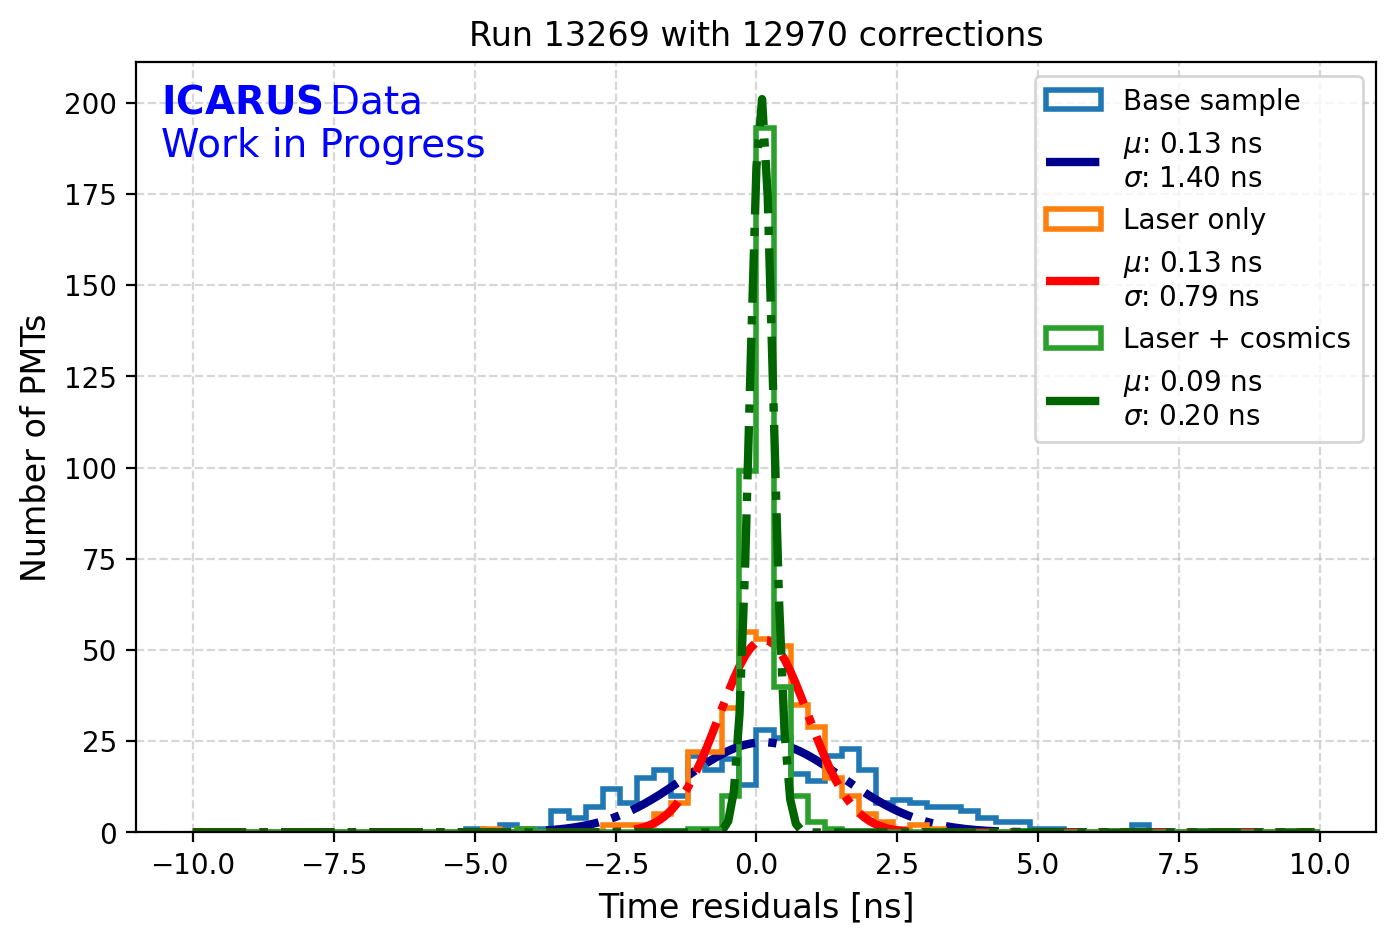

In [42]:
## Plotting residuals distribution with/without corrections
fig = plt.figure(figsize=(8,5),dpi=200)

rmin=-10
rmax=10
r=(rmin,rmax)
s=0.3
b=int((rmax-rmin)/s)

xs1, ys1, param1, param_errors1 = fitGaussian(dfnolaser,BINSIZE=s,RMIN=rmin,RMAX=rmax)
xs2, ys2, param2, param_errors2 = fitGaussian(dflaser,BINSIZE=s,RMIN=rmin,RMAX=rmax)
xs3, ys3, param3, param_errors3 = fitGaussian(dfcosmics,BINSIZE=s,RMIN=rmin,RMAX=rmax)
xss = np.arange(rmin,rmax,0.1)

### PLOT DISTRIBUTIONS
#l_nolaser = "Base sample\nMean: {:.2f} ns\nStd: {:.2f} ns".format(np.mean(dfnolaser.mean_residual_ns),np.std(dfnolaser.mean_residual_ns))
#l_laser = "Laser only\nMean: {:.2f} ns\nStd: {:.2f} ns".format(np.mean(dflaser.mean_residual_ns),np.std(dflaser.mean_residual_ns))
#l_cosmics = "Laser + cosmics\nMean: {:.2f} ns\nStd: {:.2f} ns".format(np.mean(dfcosmics.mean_residual_ns),np.std(dfcosmics.mean_residual_ns))
#plt.hist(dfnolaser.mean_residual_ns, bins=b, linewidth=2, range=r, histtype="step", label=l_nolaser)
#plt.hist(dflaser.mean_residual_ns, bins=b, linewidth=2, range=r, histtype="step", label=l_laser)
#plt.hist(dfcosmics.mean_residual_ns, bins=b, linewidth=2, range=r, histtype="step", label=l_cosmics)
#plt.legend()

### PLOT FITS
l_nolaser = "Base sample"
l_nolaserf= "$\mu$: {:.2f} ns\n$\sigma$: {:.2f} ns".format(param1[1],param1[2])
l_laser = "Laser only"
l_laserf = "$\mu$: {:.2f} ns\n$\sigma$: {:.2f} ns".format(param2[1],param2[2])
l_cosmics = "Laser + cosmics"
l_cosmicsf = "$\mu$: {:.2f} ns\n$\sigma$: {:.2f} ns".format(param3[1],param3[2])
plt.hist(dfnolaser.mean_residual_ns, bins=b, linewidth=2, range=r, histtype="step", label=l_nolaser)
plt.plot(xss,gaus(xss,*param1),"-.",color="darkblue",lw=3, label=l_nolaserf)
plt.hist(dflaser.mean_residual_ns, bins=b, linewidth=2, range=r, histtype="step", label=l_laser)
plt.plot(xss,gaus(xss,*param2),"-.",color="red",lw=3, label=l_laserf)
plt.hist(dfcosmics.mean_residual_ns, bins=b, linewidth=2, range=r, histtype="step", label=l_cosmics)
plt.plot(xss,gaus(xss,*param3),"-.",color="darkgreen",lw=3, label=l_cosmicsf)
handles, labels = plt.gca().get_legend_handles_labels()
order = [0,1,2,3,4,5] ## for just 2
#order = [2,0,3,1]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order]) 

### PLOT SINGLE
#l_cosmics = "Gaussian fit\n$\mu$: {:.2f} ns\n$\sigma$: {:.2f} ns".format(param3[1],param3[2])
#plt.hist(dfcosmics.mean_residual_ns, bins=b, linewidth=2, range=r, histtype="step")
#plt.plot(xss,gaus(xss,*param3),"-.",color="red",lw=3,label=l_cosmics)
#plt.xlim((-5,5))
#plt.legend()

watermark = r'$\mathbf{ICARUS}\,$' + 'Data\nWork in Progress'
plt.text(0.02, 0.92, watermark, fontsize=14, color='blue', alpha=1,
         ha='left', va='center', transform=plt.gca().transAxes)

plt.xlabel("Time residuals [ns]",fontsize=12)
plt.ylabel("Number of PMTs",fontsize=12)
plt.title("Run {} with {} corrections".format(run,corr))

plt.grid(linestyle="dashed",alpha=0.5)
name = "figs/run{}_base_vs_laseronly_vs_lasercosmics_w{}".format(run,corr)
plt.savefig(name+".pdf",dpi=200)
plt.show()

## Comparison between laser/cosmics residuals

In [43]:
#LASERCORR="/exp/icarus/data/users/mvicenzi/timing-database/pmt_laser_timing_data_run09628_from9772.csv"
#COSMICSCORR="output/residuals/Run_2/run{}_cosmics_timing_residuals.csv".format(corr)
#VOLTAGE="pmt_voltage_20221219.csv"

LASERCORR="/exp/icarus/data/users/mvicenzi/pmt-database/pmt_laser_timing_data/pmt_laser_timing_data_run12837_from12838.csv"
COSMICSCORR= OUTPATH + "Run_4/run{}_residuals_laseronly.csv".format(corr)
VOLTAGE="/exp/icarus/data/users/mvicenzi/pmt-database/pmt_voltage_data/pmt_voltage_data_20241109_run12837.csv"

lasercorr = pd.read_csv(LASERCORR, sep=r'\s*,\s*', engine='python')
lasercorr = lasercorr.rename(columns={'channel': 'channel_id'})
lasercorr.set_index(["channel_id"])
voltage = pd.read_csv(VOLTAGE).set_index(["channel_id"])
thisdfg = pd.read_csv(COSMICSCORR).set_index(["channel_id"])
thisdfg = thisdfg.join( lasercorr[["t_signal", "a", "b", "c"]], on="channel_id" ) 
thisdfg = thisdfg.join( voltage, on="channel_id" ) 
thisdfg["laser_res"] = thisdfg.apply( lambda x : x.t_signal-(x.a+x.b*np.power(x.voltage, x.c) ) , axis=1)

/tmp/ipykernel_1374/4191409014.py:16: RuntimeWarning: divide by zero encountered in power
  thisdfg["laser_res"] = thisdfg.apply( lambda x : x.t_signal-(x.a+x.b*np.power(x.voltage, x.c) ) , axis=1)


In [44]:
thisdfg[thisdfg.emean_ns>0.1].head()

,x,y,z,entries,pecut,mean_residual_ns,std_residual_ns,emean_ns,t_signal,a,b,c,voltage,status,laser_res
channel_id,,,,,,,,,,,,,,,
21,-371.07,29.35,-473.86,12,150.0,-2.0263,1.2410,0.1034,194.366,159.043,5048.4,-0.676699,1500,1,-0.478068
52,-371.07,-129.05,174.58,8,150.0,-1.3310,1.9669,0.2459,194.412,159.043,5048.4,-0.676699,1500,1,-0.432068
175,-49.36,-129.05,823.02,93,150.0,-0.7262,10.5553,0.1135,194.578,159.043,5048.4,-0.676699,1538,1,0.334925
178,-49.36,-76.25,872.90,151,150.0,6.1684,52.5223,0.3478,193.847,159.043,5048.4,-0.676699,1615,1,0.748550


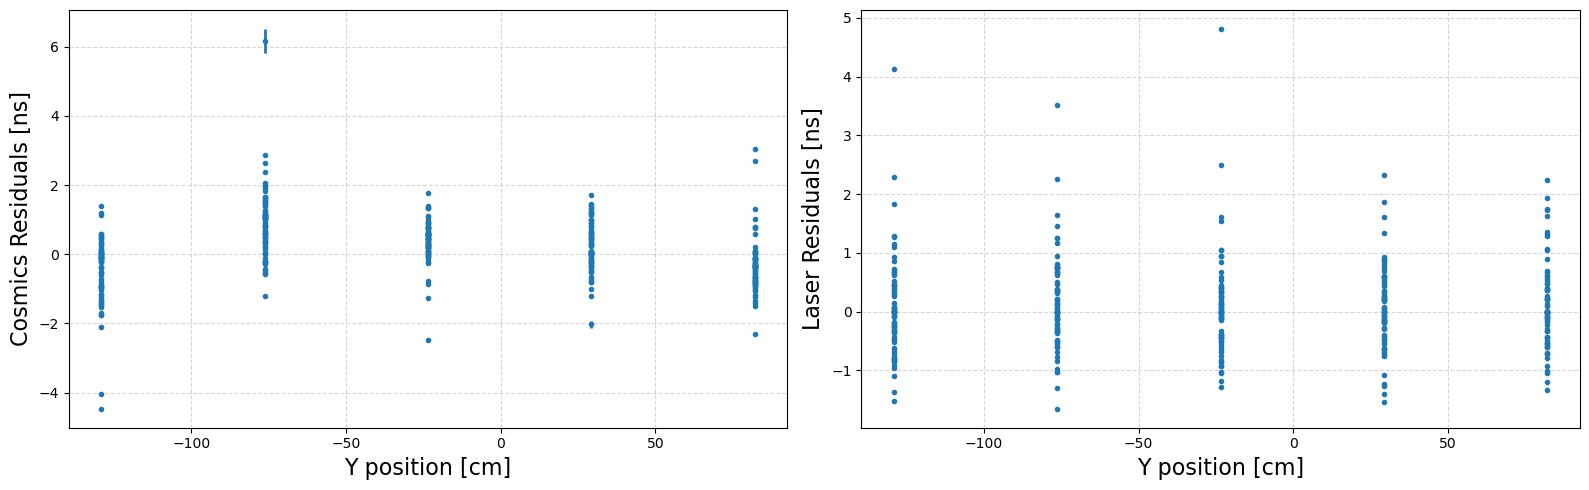

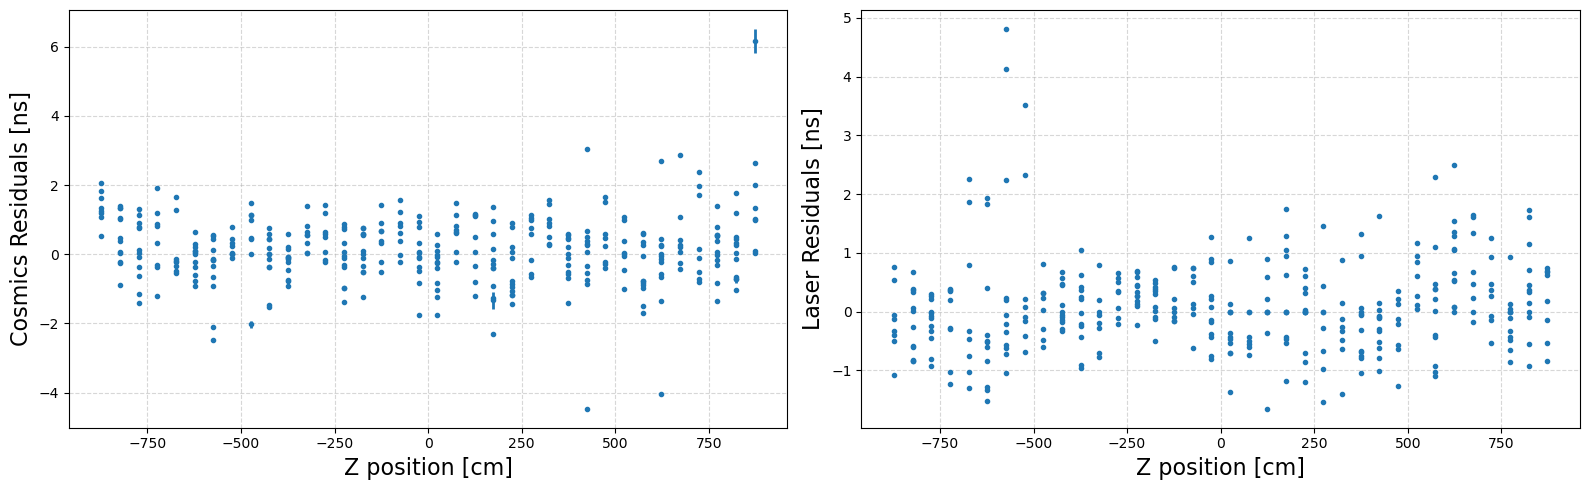

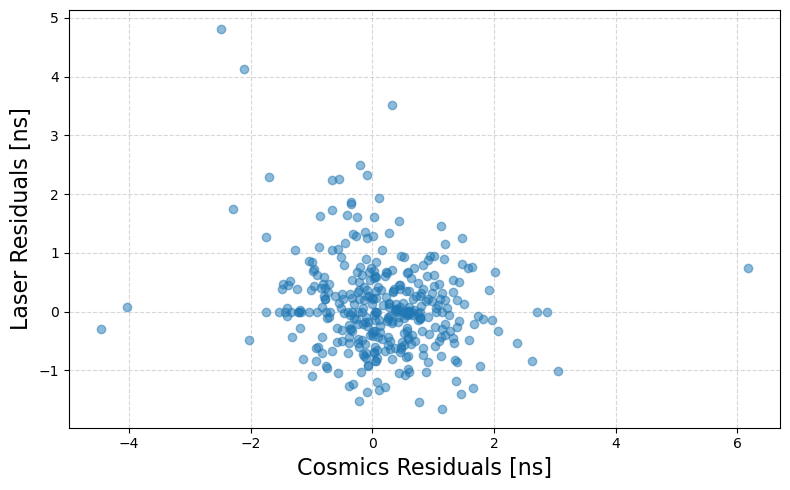

In [45]:
# Verify potential presence of biases 
fig, ax = plt.subplots(1,2, figsize=(16, 5))
ax[0].errorbar( x=thisdfg.y, y=thisdfg.mean_residual_ns, yerr=thisdfg.emean_ns, marker='.', elinewidth=2.0, lw=0 )
ax[1].errorbar( x=thisdfg.y, y=thisdfg.laser_res, yerr=0, marker='.', elinewidth=2.0, lw=0 )
ax[1].set_ylabel("Laser Residuals [ns]", fontsize=16)
ax[0].set_ylabel("Cosmics Residuals [ns]", fontsize=16)
ax[1].set_xlabel("Y position [cm]", fontsize=16)
ax[0].set_xlabel("Y position [cm]", fontsize=16)
plt.tight_layout()
ax[0].grid(alpha=0.5,linestyle="dashed")
ax[1].grid(alpha=0.5,linestyle="dashed")
plt.savefig("figs/run{}_validation_laserVScomics_Y.png".format(corr),dpi=100)
plt.show()

fig, ax = plt.subplots(1,2, figsize=(16, 5))
ax[0].errorbar( x=thisdfg.z, y=thisdfg.mean_residual_ns, yerr=thisdfg.emean_ns, marker='.', elinewidth=2.0, lw=0 )
ax[1].errorbar( x=thisdfg.z, y=thisdfg.laser_res, yerr=0, marker='.', elinewidth=2.0, lw=0 )
ax[1].set_ylabel("Laser Residuals [ns]", fontsize=16)
ax[0].set_ylabel("Cosmics Residuals [ns]", fontsize=16)
ax[1].set_xlabel("Z position [cm]", fontsize=16)
ax[0].set_xlabel("Z position [cm]", fontsize=16)
plt.tight_layout()
ax[0].grid(alpha=0.5,linestyle="dashed")
ax[1].grid(alpha=0.5,linestyle="dashed")
plt.savefig("figs/run{}_validation_laserVScomics_Z.png".format(corr),dpi=100)
plt.show()

# plot them togheter
fig, ax = plt.subplots(1,1, figsize=(8, 5))
ax.errorbar( x=thisdfg.mean_residual_ns, y=thisdfg.laser_res, yerr=0, marker='o', elinewidth=2.0, lw=0, alpha=0.5 )
ax.set_ylabel("Laser Residuals [ns]", fontsize=16)
ax.set_xlabel("Cosmics Residuals [ns]", fontsize=16)

plt.tight_layout()
plt.grid(alpha=0.5,linestyle="dashed")
plt.savefig("figs/run{}_validation_laserVScomics_2Dscatter.png".format(corr),dpi=100)
plt.show()

## Comparisons between residuals

In [46]:
f1 = OUTPATH + "Run3/run11949_residuals_laseronly.csv"
f2 = OUTPATH + "Run3/run12014_residuals_laseronly.csv"

#f1 = "output/Run_1/run8552_cosmics_timing_residuals_20230729.csv"
#f2 = "output/FINAL/cosmics_timing_residuals_t8046_from8461_offpmts_20230727.csv"

df1 = pd.read_csv(f1)
df2 = pd.read_csv(f2)

fig = plt.figure(figsize=(10,5),dpi=100)

l1 = "Run 11949\nMean: {:.2f} ns\nStd: {:.2f} ns".format(np.mean(df1.mean_residual_ns),np.std(df1.mean_residual_ns))
l2 = "Run 12014\nMean: {:.2f} ns\nStd: {:.2f} ns".format(np.mean(df2.mean_residual_ns),np.std(df2.mean_residual_ns))

plt.hist(df1.mean_residual_ns, bins=b, linewidth=2, range=r, histtype="step", label=l1)
plt.hist(df2.mean_residual_ns, bins=b, linewidth=2, range=r, histtype="step", label=l2)

plt.xlabel("Time residuals [ns]")
plt.ylabel("Number of PMTs")
plt.legend()
plt.grid(linestyle="dashed",alpha=0.5)
plt.show()

fig = plt.figure(figsize=(10,5),dpi=100)

chs = []
diffs = []
for c in df1.channel_id.to_numpy():

    aa = df1[df1.channel_id==c].mean_residual_ns.values[0]

    if len(df2[df2.channel_id==c].mean_residual_ns) < 1:
        continue

    bb = df2[df2.channel_id==c].mean_residual_ns.values[0]

    chs.append(c)
    diffs.append(aa-bb)

plt.scatter(chs, diffs)

plt.ylabel("Diff residuals [ns]")
plt.xlabel("Channel id")
plt.grid(linestyle="dashed",alpha=0.5)
plt.show()

fig = plt.figure(figsize=(10,5),dpi=100)
plt.hist(diffs, range=(-1.,1), histtype="step",bins=50)
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/exp/icarus/data/users/mvicenzi/pmt-calibration/residualsdb/Run3/run11949_residuals_laseronly.csv'

## Check bias 

In [ ]:
def check_bias(f1, f2, label1, label2):

    df = pd.read_csv(f1)
    df2 = pd.read_csv(f2)
   
    # Verify potential presence of biases 
    fig, ax = plt.subplots(1,2, figsize=(16, 5))
    ax[0].errorbar( x=df.y, y=df.mean_residual_ns, yerr=df.emean_ns, marker='.', elinewidth=2.0, lw=0, label=label1)
    ax[0].errorbar( x=df2.y, y=df2.mean_residual_ns, yerr=df2.emean_ns, marker='.', elinewidth=2.0, lw=0, label=label2 )
    ax[1].errorbar( x=df.z, y=df.mean_residual_ns, yerr=df.emean_ns, marker='.', elinewidth=2.0, lw=0 , label=label1)
    ax[1].errorbar( x=df2.z, y=df2.mean_residual_ns, yerr=df2.emean_ns, marker='.', elinewidth=2.0, lw=0, label=label2)
    ax[0].set_ylabel("Cosmics Residuals [ns]", fontsize=16)
    ax[1].set_ylabel("Cosmics Residuals [ns]", fontsize=16)
    ax[0].set_xlabel("Y position [cm]", fontsize=16)
    ax[1].set_xlabel("Z position [cm]", fontsize=16)

    plt.tight_layout()
    ax[0].grid(alpha=0.5,linestyle="dashed")    
    ax[1].grid(alpha=0.5,linestyle="dashed")
    plt.legend()
    plt.show()

In [ ]:
laser =  OUTPATH + "Run2/run9974_residuals_laseronly.csv"
cosmics = OUTPATH + "Run2/run9974_residuals_lasercosmics.csv"
check_bias(laser, cosmics, "laser corrected", "cosmics corrected")